## AI Opening Case Study

In [110]:
# load important stuff
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# These are some new scikit learn toys that will make your life easier (see below)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline

### Read data

In [67]:
import os 
os.chdir ('/Users/tangziyu/Desktop/AI Opening')

In [6]:
covid = pd.read_csv('Covid19_SourceFile.csv')
sample = pd.read_csv('1000AnalyticFileSample.csv')
dx = pd.read_csv('ICD10_Dx_TaxonomyTree.csv')
age = pd.read_csv('age.csv')

In [7]:
age.head()

,AgeCode,AgeGroup,Map to
0,1,Under 1,RefUnder18
1,2,1月17日,RefUnder18
2,3,18-24,Age_18_39
3,4,25-29,Age_18_39
4,5,30-34,Age_18_39


In [8]:
sample.head()

,Patient ID,Mortality (1= death),Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male,BEHAV_AdjustmentStress,...,UROLG_GEN_Kidney,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status_A,UROLG_GEN_Status_B,UROLG_GEN_Status2
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
dx.head()

,ICD10 Dx Code,ICD10 Dx Code Desc,DGL_1_Desc,DGL_2_Desc,DGL_3_Extend
0,F4320,"Adjustment disorder, unspecified",behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
1,F4322,Adjustment disorder with anxiety,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
2,F4323,Adjustment disorder with mixed anxiety and dep...,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
3,F4324,Adjustment disorder with disturbance of conduct,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
4,F4325,Adjustment disorder w mixed disturb of emotion...,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress


In [10]:
covid.head()

,Patient ID,AgeCode,SexCode,DX1,DX2,DX3,DX4,DX5,DX6,DX7,...,DX12,DX13,DX14,DX15,DX16,DX17,DX18,DX19,DX20,Mortality (1= death)
0,1,13,2.0,L600,J45909,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,11,2.0,Z86010,K5730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,12,2.0,Z1211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,10,1.0,Z1211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,13,2.0,Z1211,I4901,Z95810,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Data Preparation

#### convert gender to be 0-1 dummy

In [11]:
covid = covid.replace({'SexCode': 2.0}, 0)
covid['SexCode'] = covid['SexCode'].fillna(0)
convert_dict = {'SexCode': int
               } 
covid = covid.astype(convert_dict) 
covid = covid.rename(columns={'SexCode': 'Gender_Male'})

#### map age

In [12]:
covid_age = pd.merge(covid,
                 age[['AgeCode', 'Map to ']],
                 on='AgeCode')
map_age = pd.get_dummies(covid_age['Map to '])
map_age = map_age[map_age.columns[0:6]] 
covid_age = pd.concat([covid_age, map_age], axis=1)
covid_age = covid_age.drop(['AgeCode', 'Map to '],axis=1) 
covid = covid_age
covid = covid.sort_values(by=['Patient ID'])

##### check column with all nulls

In [13]:
print(covid.isnull().all())

Patient ID              False
Gender_Male             False
DX1                     False
DX2                     False
DX3                     False
DX4                     False
DX5                     False
DX6                     False
DX7                     False
DX8                     False
DX9                     False
DX10                    False
DX11                    False
DX12                    False
DX13                    False
DX14                    False
DX15                    False
DX16                    False
DX17                    False
DX18                    False
DX19                    False
DX20                    False
Mortality (1= death)    False
Age_18_39               False
Age_40_49               False
Age_50_59               False
Age_60_69               False
Age_70_74               False
Age_75_99               False
dtype: bool


#### convert code of dx to class name

In [14]:
names = ['DX1',
 'DX2',
 'DX3',
 'DX4',
 'DX5',
 'DX6',
 'DX7',
 'DX8',
 'DX9',
 'DX10',
 'DX11',
 'DX12',
 'DX13',
 'DX14',
 'DX15',
 'DX16',
 'DX17',
 'DX18',
 'DX19',
 'DX20',]
for name in names:
    covid[name] = covid[name] .map(dx.set_index('ICD10 Dx Code')['DGL_3_Extend'])

##### map dxs to be dummies according to requirements

In [15]:
covid_dx = covid
covid_dx = covid_dx.melt('Patient ID').groupby(['Patient ID', 'value']).size().unstack(fill_value=0)

In [16]:
covid_dx = covid_dx.reset_index()
covid_final = pd.merge(
                 covid[['Patient ID','Mortality (1= death)','Age_18_39','Age_40_49','Age_50_59',
                        'Age_60_69','Age_70_74','Age_75_99','Gender_Male']],covid_dx,
                 on='Patient ID')

In [17]:
covid_final.columns.tolist()

['Patient ID',
 'Mortality (1= death)',
 'Age_18_39',
 'Age_40_49',
 'Age_50_59',
 'Age_60_69',
 'Age_70_74',
 'Age_75_99',
 'Gender_Male',
 0,
 1,
 'BEHAV_AdjustmentStress',
 'BEHAV_Affective_A',
 'BEHAV_Affective_B',
 'BEHAV_Anxiety_Phobia',
 'BEHAV_Ocd_Adhd',
 'BEHAV_Other_Nos_A',
 'BEHAV_Other_Nos_B',
 'BEHAV_Personality_Conduct',
 'BEHAV_Psychosis',
 'BEHAV_Substance_Abuse',
 'CHEST_Airway_Lungs_A',
 'CHEST_Airway_Lungs_B',
 'CHEST_Chest_Wall_A',
 'CHEST_Chest_Wall_B',
 'CHEST_Complication',
 'CHEST_Lung',
 'CHEST_Metastatic',
 'CHEST_Other_Nec',
 'CHEST_Other_Nos_A',
 'CHEST_Other_Nos_B',
 'CHEST_Pers_Fam_Hx_Ds',
 'CHEST_Pleural',
 'CHEST_Pneumonia',
 'CHEST_Screening',
 'CHEST_Status_A',
 'CHEST_Status_B',
 'CHEST_Uri_A',
 'CHEST_Uri_B',
 'CVASC_Arterial_A',
 'CVASC_Arterial_B',
 'CVASC_Cardiac_A',
 'CVASC_Cardiac_B',
 'CVASC_Complication_A',
 'CVASC_Complication_B',
 'CVASC_Heart_Rhythm_A',
 'CVASC_Heart_Rhythm_B',
 'CVASC_Other',
 'CVASC_Other_Nos_A',
 'CVASC_Other_Nos_B',
 'C

##### convert 0-1 dummies

In [18]:
covid_final = covid_final.drop([0,1],axis=1) 
names = covid_final.columns.tolist()[9:]
for column in names:
    covid_final.loc[covid_final[column]!=0, column] = 1

In [19]:
# check the dummy variable - only 0 and 1
for column in names:
    print(covid_final[column].max()) 

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


#### check the results with sample data

In [20]:
covid_final.iloc[0]

Patient ID                   1
Mortality (1= death)         0
Age_18_39                    0
Age_40_49                    0
Age_50_59                    0
Age_60_69                    0
Age_70_74                    1
Age_75_99                    0
Gender_Male                  0
BEHAV_AdjustmentStress       0
BEHAV_Affective_A            0
BEHAV_Affective_B            0
BEHAV_Anxiety_Phobia         0
BEHAV_Ocd_Adhd               0
BEHAV_Other_Nos_A            0
BEHAV_Other_Nos_B            0
BEHAV_Personality_Conduct    0
BEHAV_Psychosis              0
BEHAV_Substance_Abuse        0
CHEST_Airway_Lungs_A         1
CHEST_Airway_Lungs_B         0
CHEST_Chest_Wall_A           0
CHEST_Chest_Wall_B           0
CHEST_Complication           0
CHEST_Lung                   0
CHEST_Metastatic             0
CHEST_Other_Nec              0
CHEST_Other_Nos_A            0
CHEST_Other_Nos_B            0
CHEST_Pers_Fam_Hx_Ds         0
                            ..
NEURO_Other                  0
NEURO_Ot

In [21]:
sample.columns.difference(covid_final.columns)

Index(['CVASC_Screening_A', 'DERMA_Complication', 'DERMA_Screening',
       'DERMA_Whole_Body_Nos_A', 'ENTD__Malignant_B', 'EYE___Head',
       'MSKLT_Screening', 'NEURO_Complication_B', 'NEURO_Screening'],
      dtype='object')

In [22]:
len(dx['DGL_3_Extend'].unique())

227

Besides, some of the dx don't exist in the cases - that's why we just have 220 dx instead of 229.

### Export data

In [434]:
covid_final.to_csv('final result.csv')

### Modeling

#### Text analysis

#### Most frequently appearing diseases of death

In [75]:
death = covid[covid['Mortality (1= death)']==1]
text = death.iloc[:,0:21]
text = text.drop(['Gender_Male'],axis=1) 
text = text.melt(id_vars = 'Patient ID')
text = text.iloc[:,2]
text = text.dropna()
#text.to_csv('text analysis result.csv')

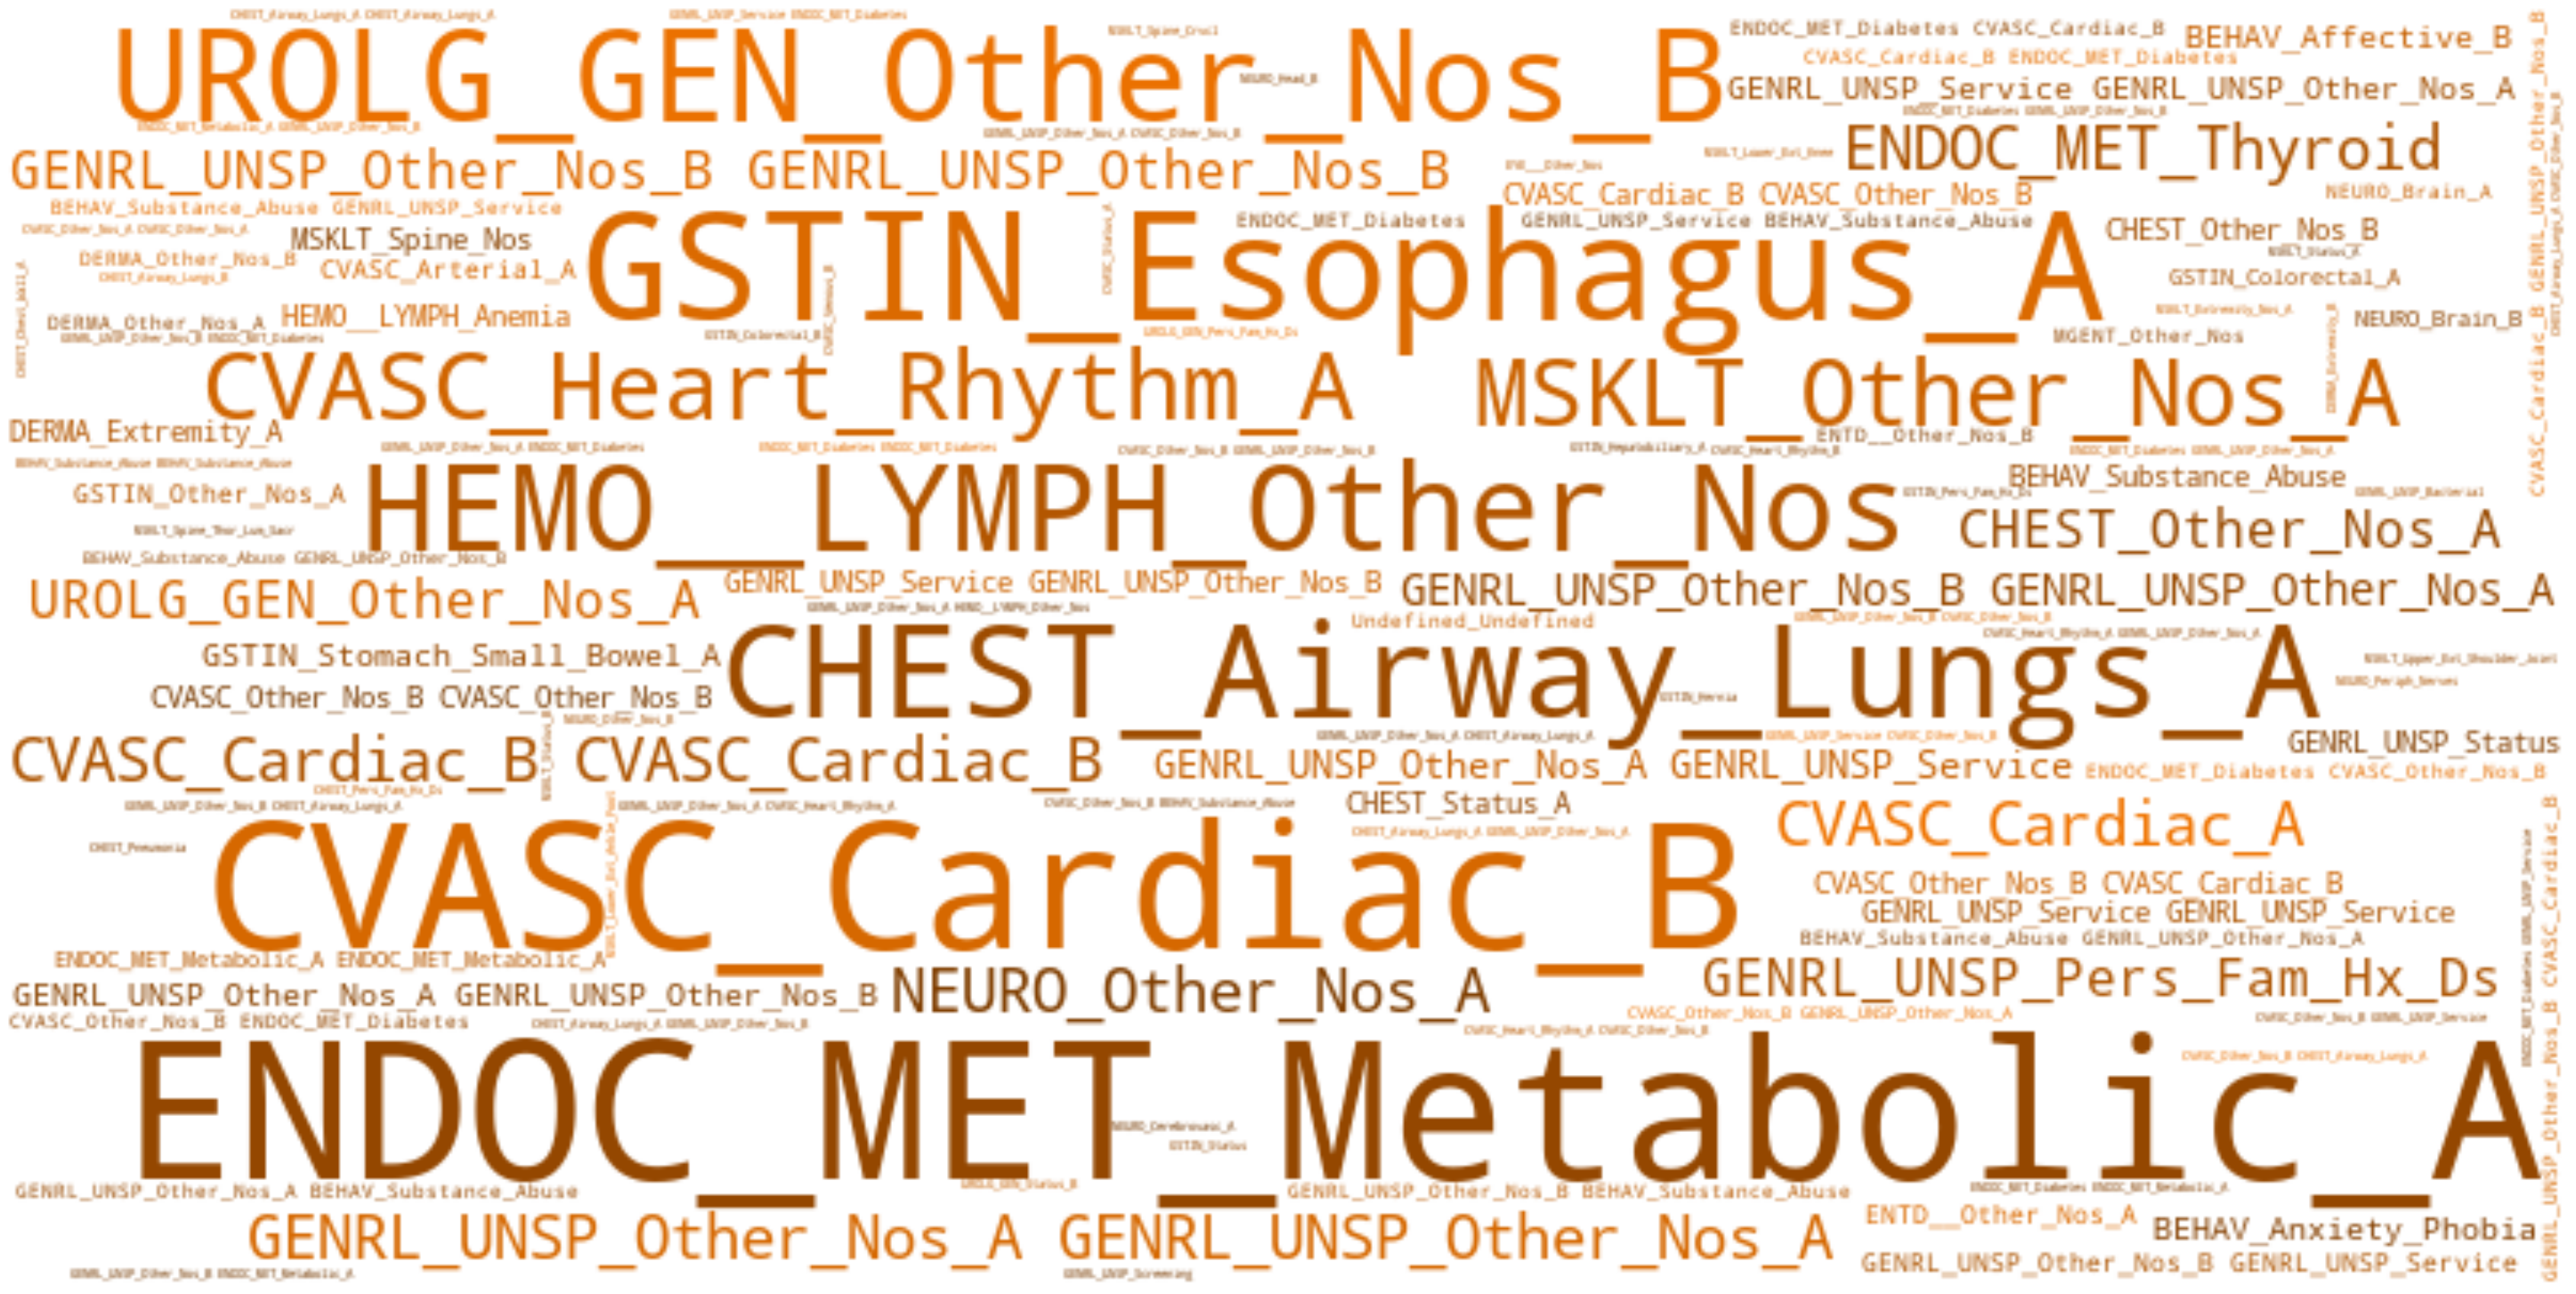

In [109]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def generate_wordcloud(word):
    word_cloud = WordCloud(width=800, height=400,background_color='white',max_font_size=60, stopwords=STOPWORDS,color_func=random_color_func).generate(words)
    plt.figure(figsize=(40,40),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_wordcloud(words)

#### Logistic regression with penalty

#### Random Forest

#### Boosted Tree

#### Neural Network